# Python:  Pixel size & dimensions

This section gives a bit of background on working with pixel sizes and dimensions in Python... which is a bit more complicated than one might first expect.

In [1]:
# First, our usual default imports
import sys
sys.path.append('../../../')

from helpers import *
import matplotlib.pyplot as plt
import numpy as np

## Pixel size

Checking the pixel size in Python has been, in my opinion, a bit of a pain - because the common libraries used to read images don't always make that information very easy to access.

The situation is improving though.

Here, we'll look at accessing pixel size information using two popular image-reading libraries:
* [`imageio`](https://pypi.org/project/imageio/) - which very commonly used, and makes reading lots of common image types straightforward
* [`AICSImageIO`](https://pypi.org/project/aicsimageio/3.2.1/) - which is a bit more complex, but has some *extremely* useful features for working with scientific images

### ImageIO

To explore pixel sizes with `imageio`, let's return to the neuron image used in the 'Channels & colors' chapter.

The following code shows how we can read both the pixel values and the metadata.

In [2]:
# In preparation for the future, we'll use the 'v3' imageio process
import imageio.v3 as iio

# Get the path to the image (this is a specific helper function for this book)
path = find_image('Rat_Hippocampal_Neuron.tif')[0]

# Read the pixel values
im_iio = iio.imread(path)

# Read & print the metadata
metadata = iio.immeta(path)
print(metadata)

{'byteorder': '>', 'is_imagej': True, 'ImageJ': '1.44o', 'images': 5, 'channels': 5, 'mode': 'color', 'unit': 'um', 'loop': False, 'min': 472.0, 'max': 2436.0, 'Info': 'This is a composite confocal image of primary hippocampal neurons.\nHigh affinity bungarotoxin receptors were stained with fluorescent \nbungarotoxin (c=1). The nicotinic acetylcholine alpha7 subunit is \nimmunofluorescently labeled (c=2). A nAChR chaperone protein fused \nwith CFP was transiently transfected into the neurons (c=3). Nuclei \nwere dyed with Hoechst (c=4). A Nomarski optics image shows the \nmorphology of the neuron (c=5). Image is courtesy of John Alexander.\n', 'Ranges': (472.0, 2436.0, 548.3125, 2935.75, 504.84765625, 942.6484375, 518.359375, 3141.347237880496, 1937.9375, 3136.4940476190477), 'LUTs': [array([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35, 

The metadata contains a lot of info, even including lookup tables.

Printing it a little more nicely (and skipping the LUTs), we get:

In [3]:
for k, v in metadata.items():
    if not 'LUTs' in k:
        print(f'{k}: {v}')

byteorder: >
is_imagej: True
ImageJ: 1.44o
images: 5
channels: 5
mode: color
unit: um
loop: False
min: 472.0
max: 2436.0
Info: This is a composite confocal image of primary hippocampal neurons.
High affinity bungarotoxin receptors were stained with fluorescent 
bungarotoxin (c=1). The nicotinic acetylcholine alpha7 subunit is 
immunofluorescently labeled (c=2). A nAChR chaperone protein fused 
with CFP was transiently transfected into the neurons (c=3). Nuclei 
were dyed with Hoechst (c=4). A Nomarski optics image shows the 
morphology of the neuron (c=5). Image is courtesy of John Alexander.

Ranges: (472.0, 2436.0, 548.3125, 2935.75, 504.84765625, 942.6484375, 518.359375, 3141.347237880496, 1937.9375, 3136.4940476190477)
is_svs: False
is_vista: False
is_tiffep: False
is_mrc: False
is_dng: False
is_ome: False
is_multipage: False
is_ndpi: False
is_sem: False
is_bif: False
is_fluoview: False
is_philips: False
is_astrotiff: False
is_volumetric: False
is_andor: False
is_mediacy: False
is_

This metadata is actually quite ImageJ-specific, and other TIFFs may give quite different metadata.

We can see the version of ImageJ that wrote the file, but picking out the key thing we want here - the pixel size - is not so easy.

Seeing `unit=um` is encouraging, but not enough.

We can explore a bit more with 'properties', which imageio described as ['a curated set of standardized metadata'](https://imageio.readthedocs.io/en/v2.30.0/reference/userapi.html#metadata).

In [4]:
properties = iio.improps(path, extension=".tif")
print(properties)

ImageProperties(shape=(512, 512), dtype=dtype('uint16'), n_images=None, is_batch=False, spacing=(6.25, 6.25))


Here, the `spacing=(6.25, 6.25)` seems promising.

It's tempting to suppose that means the pixel width and height are both 6.25 µm - *however* if I check the same image in ImageJ itself, I see the pixel width and height are actually 0.16 µm... which happens to equal 1.0/6.25 µm.

In [5]:
print(1.0 / 6.25)

0.16


Therefore the information **is** in the metadata, but it's very easy to misinterpret - and it isn't even guaranteed to be correct if the image was written by some other software.

So while `imageio` is excellent for reading images easily - generally just a quick `im = imread(path)` - it's not necessarily the best thing to use when pixel sizes (or other metadata) matter.

### Using AICSImageIO

The best alternative I know for working with scientific (especially biomedical) images is [**AICSImageIO**](https://github.com/AllenCellModeling/aicsimageio).
This is a really useful Python library that standardizes reading and writing multiple file formats - and, depending upon how it's installed, can even access lots more awkward proprietary file formats with the help of [Bio-Formats](http://www.openmicroscopy.org/bio-formats/).

Although it's possible to use a version of `imread` with AICSImageIO, it's worth learning the alternative way of doing things by creating an `AICSImage` object.
This provides us with a way to access pixels and lots of other useful things whenever we need them.

In [6]:
from aicsimageio.aics_image import AICSImage

# Create an AICSImage
img_aics = AICSImage(path)

# Print its main attributes
print(img_aics)
for d in dir(img_aics):
    if not d.startswith('_'):
        print(d)

<AICSImage [Reader: TiffReader, Image-is-in-Memory: False]>
ReaderClass
SUPPORTED_READERS
channel_names
current_scene
current_scene_index
dask_data
data
determine_reader
dims
dtype
get_dask_stack
get_image_dask_data
get_image_data
get_mosaic_tile_position
get_stack
get_xarray_dask_stack
get_xarray_stack
metadata
mosaic_tile_dims
ome_metadata
physical_pixel_sizes
reader
reader_path
reader_paths
save
scenes
set_scene
shape
xarray_dask_data
xarray_data


/usr/share/miniconda/envs/bioimage-book/lib/python3.10/site-packages/pydantic/_migration.py:283: UserWarning: `pydantic.error_wrappers:ValidationError` has been moved to `pydantic:ValidationError`.
  warnings.warn(f'`{import_path}` has been moved to `{new_location}`.')


From this, we can immediately see the attribute that will provide us with pixel sizes directly.

In [7]:
print(img_aics.physical_pixel_sizes)

PhysicalPixelSizes(Z=None, Y=0.16, X=0.16)


One perhaps non-obvious thing to know when using AICSImageIO is that the `AICSImage` isn't a regular NumPy array of the kind that `imageio.imread` would return.
Rather, if you want that, you need to request the data.

Using this knowledge, we can check that we have the same mean pixel value for both - as a quick way to ascertain that the actual pixel values are likely to match.

In [8]:
print(f'Mean pixel value from imageio:      {im_iio.mean():.2f} (total pixel count {im_iio.size})')
print(f'Mean pixel value from AICSImageIO:  {img_aics.data.mean():.2f} (total pixel count {img_aics.data.size})')

Mean pixel value from imageio:      1038.69 (total pixel count 1310720)
Mean pixel value from AICSImageIO:  1038.69 (total pixel count 1310720)


## Dimensions

### Array shapes and dimensions

We've seen how two different libraries can enable us to read the same pixel values as NumPy arrays and extract pixel size information.

We might well expect that the NumPy arrays representing the pixel values are the same, but in fact we can't count on that.

NumPy is incredibly flexible when it comes to handling multidimensional arrays. 
And while that flexibility can be really helpful, it can also complicate things.

To see it in action, let's check the dimensions of the images we read using imageio and AICSImageIO.

In [9]:
# Print shape of image read by imageio
import imageio.v3 as iio
path = find_image('Rat_Hippocampal_Neuron.tif')[0]
im_iio = iio.imread(path)
print(f'Shape of image read by imageio:     {im_iio.shape}')

# Print shape of image read by AICSImageIO
from aicsimageio.aics_image import AICSImage
im_aics = AICSImage(path).data
print(f'Shape of image read by AICSImageIO: {im_aics.shape}')

print(f'Arrays the same? {np.array_equal(im_aics, im_iio)}')

Shape of image read by imageio:     (5, 512, 512)
Shape of image read by AICSImageIO: (1, 5, 1, 512, 512)
Arrays the same? False


We can see the number of pixels are the same, but there are some extra 'singleton' dimensions stuck into the results from AICSImageIO (i.e. with length `1`).

Fortunately, we can easily remove them with an `np.squeeze` - and end up with the same arrays.

In [10]:
im_aics_squeezed = np.squeeze(im_aics)
print(f'Shape of image read by AICSImageIO & squeezed: {im_aics_squeezed.shape}')

print(f'Arrays the same? {np.array_equal(im_aics_squeezed, im_iio)}')

Shape of image read by AICSImageIO & squeezed: (5, 512, 512)
Arrays the same? True


So a natural question is: **why has AICSImageIO snuck in some extra dimensions?**

Before answering that, we should ask ourselves something else.
**What exactly do we _have_ along the dimension of length `5`?**

And this is where things aren't terribly clear with imageio.

`5` *could* be the width of the image, height of the image, number of channels, number of z-slices, or number of timepoints.

Based upon our knowledge of images and the other dimensions, we'd be justified in expecting that the `5` doesn't correspond to the image width or height - `512` seems more likely for those - so it's probably one of the others.

But the problem is that **we have no way of knowing** without further information.
If we don't have some external source to tell us, we need to poke around the metadata or look at the contents to figure out the answer.

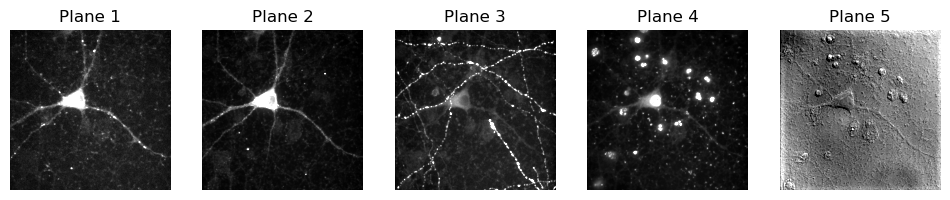

In [11]:
# Loop through the first dimension and show images for each plane
n_slices = im_iio.shape[0]
plt.figure(figsize=(12, 4))
for ii in range(n_slices):
    plt.subplot(1, n_slices, ii+1)
    plt.title(f'Plane {ii+1}')
    show_image(im_iio[ii], clip_percentile=1)

To me, that looks very much like we have 5 different channels.
I'm making some assumptions there... but they seem pretty safe assumptions.

However AICSImageIO removes this ambiguity in a couple of ways.
1. You can expect `AICSImage` to return a 5D array, with the dimensions in a consistent order: `TCZYX` (although there is at least one caveat in the next section!)
2. You can easily query the dimensions and order to be sure

In [12]:
image = AICSImage(path)
print(image.dims)
print(f'Shape: {image.dims.shape}')
print(f'Order: {image.dims.order}')

<Dimensions [T: 1, C: 5, Z: 1, Y: 512, X: 512]>
Shape: (1, 5, 1, 512, 512)
Order: TCZYX


### Where are my channels?!?

We've seen above that imageio can return a 5-channel image with the channels first.
Our question here is: does it always do that?

The answer, alas, is no.
The location of the channels dimensions is painfully uncertain in Python, and often different tools expect it to be in different places.

Or sometimes the *same* tool might put it in a different place.

To see that in action, let's read a simple RGB image with imageio.

In [13]:
path = find_image('leaf.jpg')[0]
im_iio = iio.imread(path)
print(im_iio.shape)

(446, 507, 3)


An RGB image has 3 channels - red, green and blue - but it seems that suddenly we have the channels dimension last.

Why?

I don't have a very satisfying explanation, except to say that for RGB that's often what you want because matplotlib expects the channels to be last, and we often use matplotlib to show images.

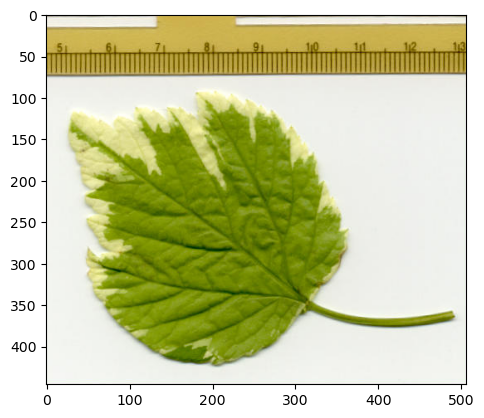

In [14]:
# Show an RGB image with channels-last using matplotlib
from matplotlib import pyplot as plt

path = find_image('leaf.jpg')[0]
im_iio = iio.imread(path)
plt.imshow(im_iio)
plt.show()

It's not *always* what you want though, and if you get enough deep learning then you'll find the 'channels-first' or 'channels-last' question coming up often.

With that in mind, we can use NumPy to shift from so-called 'channels-last' to 'channels-first' - but matplotlib won't like that very much.

My new shape: (3, 446, 507)
I can't show that, sorry! Invalid shape (3, 446, 507) for image data


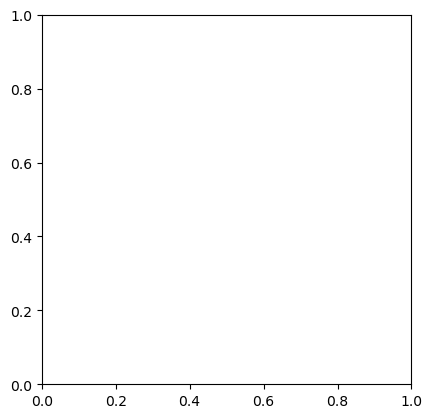

In [15]:
# *Try* to show an RGB image with channels-first using matplotlib

im_iio_channels_first = np.moveaxis(im_iio, source=-1, destination=0)
print(f'My new shape: {im_iio_channels_first.shape}')

try:
    plt.imshow(im_iio_channels_first)
    plt.show()
except Exception as ex:
    print(f"I can't show that, sorry! {ex}")

So imageio might get channels at the start or the end.
For RGB, it seems to prefer the end.

What does AICSImageIO do?

Since I said AICSImageIO is consistent, I'd like to say it puts the channels in the same place for the RGB and 5-channel image... but no.
It also treats RGB as a special case.

In [16]:
image = AICSImage(path)

print(image.shape)
print(image.dims.order)

(1, 1, 1, 446, 507, 3)
TCZYXS


It's a little hard to find, but the AICSImageIO documentation mentions that [you can expect 5 dimensions for non-RGB images, but RGB images have 6 dimensions](https://allencellmodeling.github.io/aicsimageio/aicsimageio.readers.html#aicsimageio.readers.bioformats_reader.BioFile.to_numpy) - where the sixth is called `S` for `Samples`.

The good thing is that, assuming you don't have anything else going on with the first 3 dimensions - i.e. they are just `(1, 1, 1)` - a simple `np.squeeze` is enough to convert the pixel array into a matplotlib-friendly channels-last RGB format.

## More dimensions

We'll end this section by looking at an image with 2 channels and 25 z-slices.

> Since you now know how to explore the dimensions in detail, I'll use my `load_image` helper function for convenience... which returns a NumPy array that's pre-squeezed to remove any singleton dimensions.

In [17]:
im = load_image('confocal-series.zip')
print(f'Shape: {im.shape}')

Shape: (25, 2, 400, 400)


Since we already considered how to view multichannel images in the last chapter, let's extract a single channel here.

In [18]:
# Channels come second
# This gives us all the z-slices (:), the first channel (0), everything else (...)
im_single = im[:, 0, ...]
print(f'New shape: {im_single.shape}')

New shape: (25, 400, 400)


At this point, NumPy becomes quite fun - because it is *so easy* to do stuff along different dimensions.

For example, we can rapidly generate different z-projections.

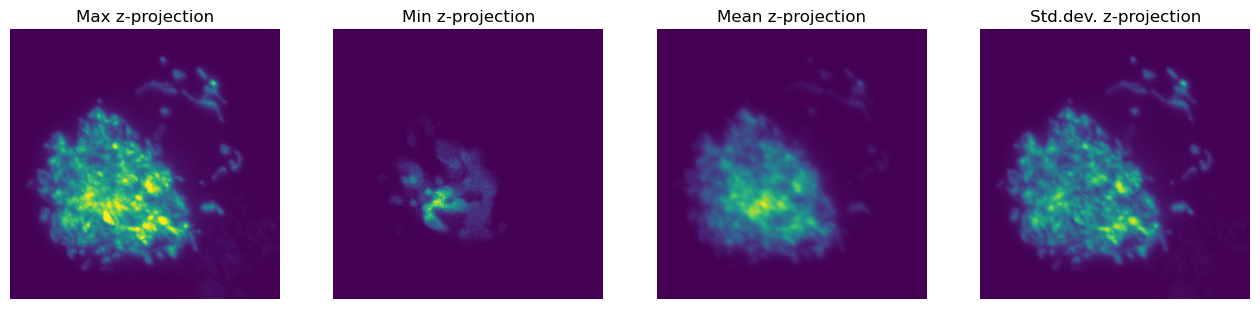

In [19]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.imshow(im_single.max(axis=0))
plt.axis(False)
plt.title('Max z-projection')

plt.subplot(1, 4, 2)
plt.imshow(im_single.min(axis=0))
plt.axis(False)
plt.title('Min z-projection')

plt.subplot(1, 4, 3)
plt.imshow(im_single.mean(axis=0))
plt.axis(False)
plt.title('Mean z-projection')

plt.subplot(1, 4, 4)
plt.imshow(im_single.std(axis=0))
plt.axis(False)
plt.title('Std.dev. z-projection')

plt.show()

But we're not limited to projecting along z - we can just switch the `axis` value and project along some other dimension.

> Note that this won't do any correction for differences in pixel size in xy vs. z. With only 25 z-slices, these projections look extremely squashed.

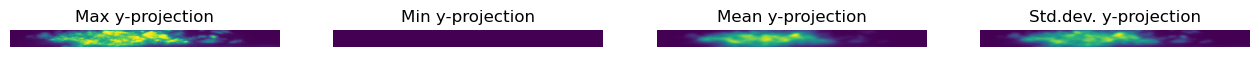

In [20]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.imshow(im_single.max(axis=1))
plt.axis(False)
plt.title('Max y-projection')

plt.subplot(1, 4, 2)
plt.imshow(im_single.min(axis=1))
plt.axis(False)
plt.title('Min y-projection')

plt.subplot(1, 4, 3)
plt.imshow(im_single.mean(axis=1))
plt.axis(False)
plt.title('Mean y-projection')

plt.subplot(1, 4, 4)
plt.imshow(im_single.std(axis=1))
plt.axis(False)
plt.title('Std.dev. y-projection')

plt.show()

And we can also slice wherever we like as well, to obtain orthogonal views.

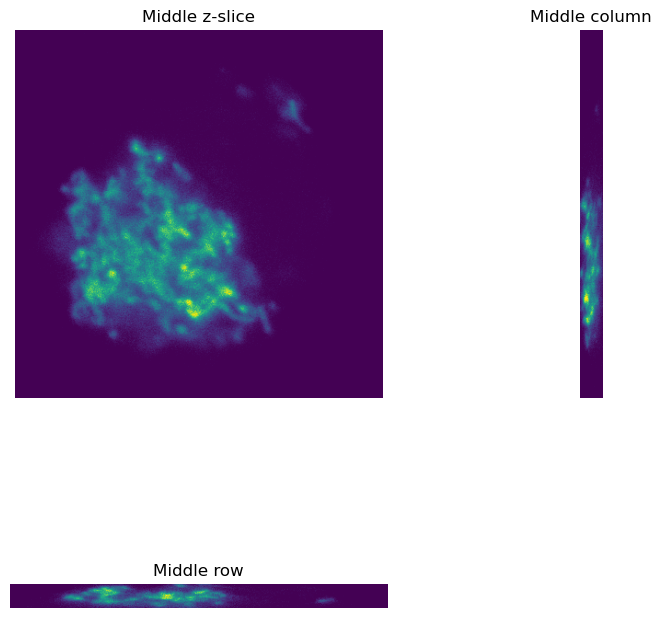

In [21]:
plt.figure(figsize=(8, 8))

plt.subplot(2, 2, 1)
plt.imshow(im_single[im_single.shape[0]//2, ...])
plt.axis(False)
plt.title('Middle z-slice')

plt.subplot(2, 2, 3)

plt.imshow(im_single[:, im_single.shape[1]//2, ...])
plt.axis(False)
plt.title('Middle row')

plt.subplot(2, 2, 2)
plt.imshow(im_single[..., im_single.shape[2]//2].transpose())
plt.axis(False)
plt.title('Middle column')

plt.tight_layout()
plt.show()